In [18]:
import torch
import numpy as np

seed = 2
torch.manual_seed(seed)
np.random.seed(seed)

# get task vectors. all orthogonal
dim = 10
n_task = 40
gaus = torch.randn(dim, dim)
#u, s, v = torch.svd(gaus)
u = torch.randn(n_task, dim)
u = u/torch.norm(u, dim=1, keepdim=True)

# power law distribution
alpha = 2
prob = 1/(np.arange(n_task) + 1)**(alpha)
prob /= np.sum(prob)

noise_scale = 0e-3


task_vectors = u[:n_task]

batch_size = 128

# initial and target
x = torch.nn.Parameter(torch.zeros(dim,))

learning_rate = 1e-3
#optimizer = torch.optim.SGD([x], lr=learning_rate)
optimizer = torch.optim.Adam([x], lr=learning_rate, betas=(0.0,0.0))
target = torch.sum(task_vectors, dim=0)


n_steps = 3000
log = 500
task_abilities = []
losses = []
losses_skill = []
n_uses = []


for i in range(n_steps):

    optimizer.zero_grad()

    # project and get progress
    task_ability = task_vectors @ x
    
    loss = np.sum((1 - task_ability.detach().numpy()) ** 2 * prob)
    task_abilities.append(task_ability.detach().numpy())
    losses.append(loss)
    losses_skill.append((1 - task_ability.detach().numpy()) ** 2)

    # mimic gradient
    id = np.random.choice(n_task, batch_size, p=prob)
    task_vectors_batch = task_vectors[id]
    task_ability_batch = task_ability[id]
    
    #neg_grad_per_sample = (1-task_ability_batch).unsqueeze(dim=1)
    #neg_grad_per_sample = torch.abs(1-task_ability_batch).unsqueeze(dim=1) ** (1) * torch.sign((1-task_ability_batch).unsqueeze(dim=1))

    #neg_grad = torch.mean(task_vectors_batch*neg_grad_per_sample, dim=0)
    loss = torch.mean((1-task_ability_batch)**2)
    loss.backward()
    
    # update 
    #x.grad = - neg_grad + torch.randn(dim) * noise_scale
    optimizer.step()
    
    neg_grad = - x.grad.detach()
    
    # compute #(used dimension)
    alignment = task_vectors * neg_grad[None, :] > 0
    n_used = torch.sum(alignment, dim=1)
    n_uses.append(n_used.detach().numpy())
    
    if i % log == 0:
        print(i)

task_abilities = np.array(task_abilities)
losses = np.array(losses)
n_uses = np.array(n_uses)
losses_skill = np.array(losses_skill)

0
500
1000
1500
2000
2500


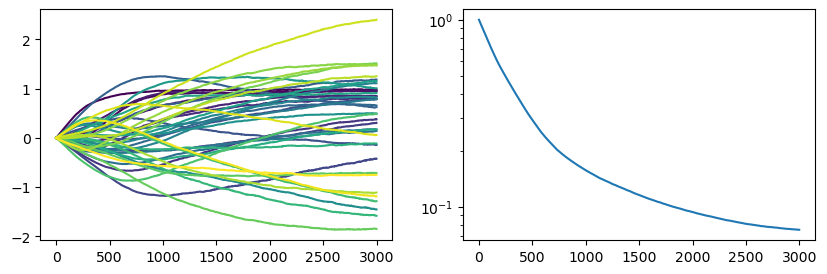

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))

cmap = plt.get_cmap('viridis') 

plt.subplot(1,2,1)

for i in range(n_task):
    plt.plot(task_abilities[:,i], color=cmap(i/(n_task-1)))
    
#plt.xlim(1,300)
#plt.xscale('log')
    
plt.subplot(1,2,2)
plt.plot(losses)
plt.yscale('log')


In [11]:
Cij = (task_vectors @ task_vectors.T).detach().numpy()

In [16]:
import copy

l = np.ones(n_task,)

lr = 2 * learning_rate * np.sqrt(dim)
n_steps2 = 5000

ls = []

for i in range(n_steps2):
    fg = prob * l
    nominator = (Cij @ fg[:,None])[:,0]
    fg_norm = nominator/(np.sum(fg) + 0.01)
    l -= lr * fg_norm
    #l = np.maximum(l, 0.)
    #l = np.exp(-lr*prob/(np.sum(fg)+0.01)) * l
    ls.append(copy.deepcopy(l))
    
ls = np.array(ls)

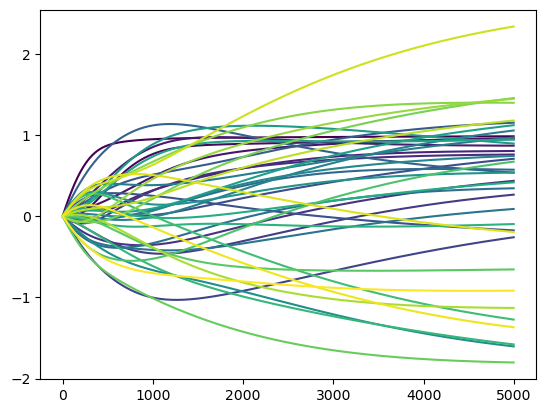

In [17]:
for i in range(n_task):
    plt.plot(1-ls[:,i], color=cmap(i/(n_task-1)))

In [1]:
import torch
import numpy as np
import copy



n_tasks = [5,10,20,40,100]

results = {}

for n_task in n_tasks:
    
    print('n_task=', n_task)

    seed = 2
    torch.manual_seed(seed)
    np.random.seed(seed)

    # get task vectors. all orthogonal
    dim = 10
    #n_task = 40
    gaus = torch.randn(dim, dim)
    #u, s, v = torch.svd(gaus)
    u = torch.randn(n_task, dim)
    u = u/torch.norm(u, dim=1, keepdim=True)

    # power law distribution
    alpha = 2
    prob = 1/(np.arange(n_task) + 1)**(alpha)
    prob /= np.sum(prob)

    noise_scale = 0e-3


    task_vectors = u[:n_task]

    batch_size = 128

    # initial and target
    x = torch.nn.Parameter(torch.zeros(dim,))

    learning_rate = 1e-3
    #optimizer = torch.optim.SGD([x], lr=learning_rate)
    optimizer = torch.optim.Adam([x], lr=learning_rate, betas=(0.0,0.0))
    target = torch.sum(task_vectors, dim=0)


    n_steps = 3000
    log = 500
    task_abilities = []
    losses = []
    losses_skill = []
    n_uses = []


    for i in range(n_steps):

        optimizer.zero_grad()

        # project and get progress
        task_ability = task_vectors @ x

        loss = np.sum((1 - task_ability.detach().numpy()) ** 2 * prob)
        task_abilities.append(task_ability.detach().numpy())
        losses.append(loss)
        losses_skill.append((1 - task_ability.detach().numpy()) ** 2)

        # mimic gradient
        id = np.random.choice(n_task, batch_size, p=prob)
        task_vectors_batch = task_vectors[id]
        task_ability_batch = task_ability[id]

        loss = torch.mean((1-task_ability_batch)**2)
        loss.backward()

        # update 
        #x.grad = - neg_grad + torch.randn(dim) * noise_scale
        optimizer.step()

        neg_grad = - x.grad.detach()

        # compute #(used dimension)
        alignment = task_vectors * neg_grad[None, :] > 0
        n_used = torch.sum(alignment, dim=1)
        n_uses.append(n_used.detach().numpy())

        if i % log == 0:
            print(i)

    exp = np.array(task_abilities)

    results[f"exp_{n_task}"] = exp

    Cij = (task_vectors @ task_vectors.T).detach().numpy()

    l = np.ones(n_task,)

    lr = 2 * learning_rate * np.sqrt(dim)
    n_steps2 = 3000

    ls = []

    for i in range(n_steps2):
        fg = prob * l
        nominator = (Cij @ fg[:,None])[:,0]
        fg_norm = nominator/(np.sum(fg) + 0.01)
        l -= lr * fg_norm
        #l = np.maximum(l, 0.)
        #l = np.exp(-lr*prob/(np.sum(fg)+0.01)) * l
        ls.append(copy.deepcopy(l))

    ls = np.array(ls)
    theory = 1 - ls
    
    results[f"theory_{n_task}"] = theory

n_task= 5
0
500
1000
1500
2000
2500
n_task= 10
0
500
1000
1500
2000
2500
n_task= 20
0
500
1000
1500
2000
2500
n_task= 40
0
500
1000
1500
2000
2500
n_task= 100
0
500
1000
1500
2000
2500


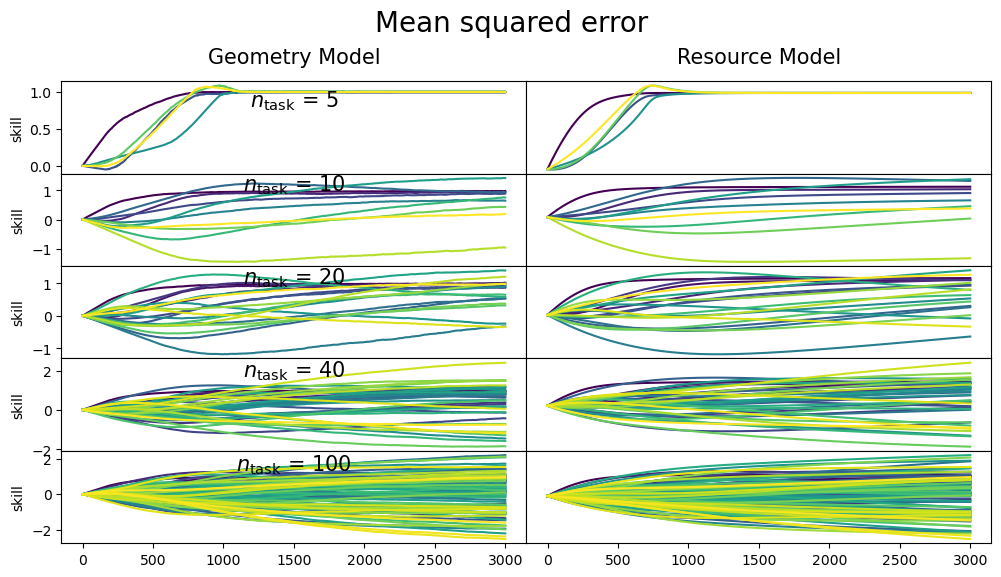

In [2]:
import matplotlib.pyplot as plt

ii = 0

plt.figure(figsize=(12,6))

cmap = plt.get_cmap('viridis') 

n_tasks = [5,10,20,40,100]

for n_task in n_tasks:

    theory = results[f'theory_{n_task}']
    experiment = results[f'exp_{n_task}']

    plt.subplot(5,2,2*ii+1)

    for i in range(n_task):
        plt.plot(experiment[:,i], color=cmap(i/(n_task-1)))
        

    #plt.ylim(-0.05,1.3)
    
    plt.ylabel('skill', fontsize=10)
    
    x0 = 1500
    y0s = [0.8,1,1.0,1.7,1.3]
    
    plt.text(x0, y0s[ii], r"$n_{\rm task}$ = "+str(n_task), fontsize = 15, horizontalalignment='center')
    
    if ii == 3:
        plt.xlabel('training steps', fontsize=10)
        
    if ii == 0:
        plt.title('Geometry Model', fontsize=15, y=1.1)

    plt.subplot(5,2,2*ii+2)

    for i in range(n_task):
        plt.plot(theory[:,i], color=cmap(i/(n_task-1)))
        
        
    #plt.text(x0, y0, r"$N_0$ = "+"0.01", fontsize = 12, horizontalalignment='center')
        
    plt.yticks([])
    
    if ii == 0:
        plt.title('Resource Model', fontsize=15, y=1.1)
    
    #plt.ylim(-0.05,1.3)
    
    if ii == 3:
        plt.xlabel('training steps', fontsize=10)
        
    ii += 1
    
plt.suptitle('Mean squared error', fontsize=20, y=1.0)
        
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('./plot/underparam_mse.pdf', bbox_inches='tight')